# MATH70121 - Topics in Derivative Pricing
## Inflation seasonality and curve 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
plt.style.use('ggplot')

In [2]:
# path to the folder containing the files (require a slash at the end)
path_to_savedata = "data/"
path_to_savefig = "plots/"

## Q1 - Data Exploration

Notes: Release date of our RPI monthly change dataset: 20 March 2024

In [3]:
# path to the csv file
path_to_unfiltered_RPI_ts = "data/unfiltered_RPI_ts.csv"
path_to_filtered_RPI_ts = "data/filtered_RPI_ts.csv"

unfiltered_RPI_ts = pd.read_csv(path_to_unfiltered_RPI_ts, header=None)
filtered_RPI_ts = pd.read_csv(path_to_filtered_RPI_ts, header=None)

In [4]:
# Check the difference between the two time series
mask = (pd.read_csv(path_to_unfiltered_RPI_ts, header=None) == pd.read_csv(path_to_filtered_RPI_ts, header=None))

print(unfiltered_RPI_ts[~mask.iloc[:,1]])
print(filtered_RPI_ts[~mask.iloc[:,1]])

                 0    1
3          PreUnit  NaN
7  Important notes  NaN
                 0    1
3          PreUnit  NaN
7  Important notes  NaN


In [5]:
# No difference in numerical value
# Choose one as our object time series
object_RPI_ts = unfiltered_RPI_ts

In [6]:
# Pre-precessing out datesets
dataset_info = object_RPI_ts.iloc[:8].copy()
print(dataset_info)

RPI_pct_change_ts = object_RPI_ts.iloc[8:].copy()
RPI_pct_change_ts.iloc[:,1] = RPI_pct_change_ts.iloc[:,1].astype(float)
RPI_pct_change_ts.index.name = None
RPI_pct_change_ts_monthly = RPI_pct_change_ts[36:].copy()

RPI_pct_change_ts_monthly.iloc[:,0] = pd.to_datetime(RPI_pct_change_ts_monthly.iloc[:,0], format='%Y %b')
RPI_pct_change_ts_monthly.set_index(0, inplace=True)
RPI_pct_change_ts_monthly.index.name = None
RPI_pct_change_ts_monthly.rename(columns={1: 'RPI_pct_change'}, inplace=True)

                   0                                               1
0              Title  RPI:Percentage change over 1 month - All items
1               CDID                                            CZEQ
2  Source dataset ID                                            MM23
3            PreUnit                                             NaN
4               Unit                                               %
5       Release date                                      20-03-2024
6       Next release                                   17 April 2024
7    Important notes                                             NaN


In [7]:
# Only include data after 1987 rebasing
starting_RPI = 100.
RPI_pct_change_ts_monthly_new = RPI_pct_change_ts_monthly[RPI_pct_change_ts_monthly.index >= "1987-01"].copy()

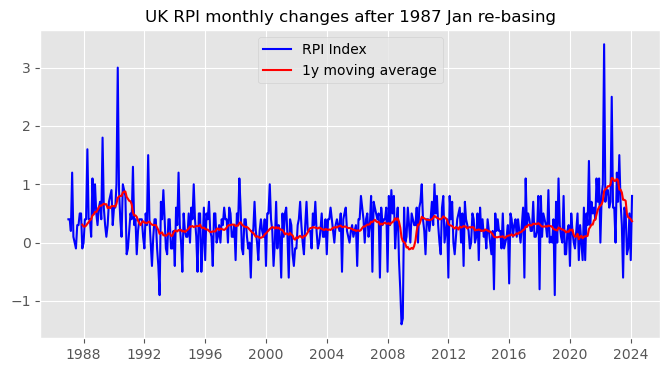

In [8]:
# viualisation of RPI monthly change
plt.figure(figsize=(8,4))
plt.plot(RPI_pct_change_ts_monthly_new, 'b-', label='RPI Index')
plt.plot(RPI_pct_change_ts_monthly_new.rolling(window=12).mean(), 'r-', label='1y moving average')
plt.title('UK RPI monthly changes after 1987 Jan re-basing', size=12)
plt.legend()
plt.savefig(path_to_savefig + 'RPI_pct_change.png')

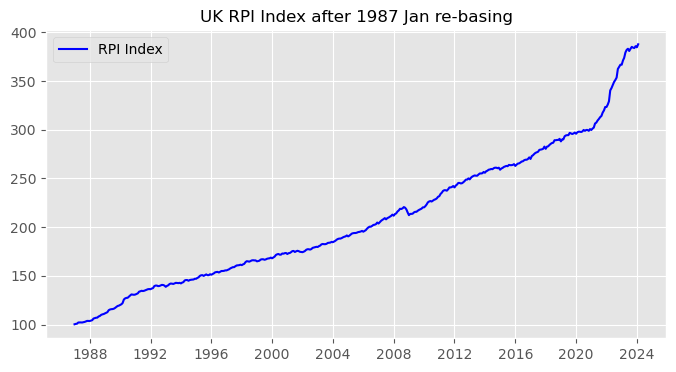

In [9]:
# viualisation of RPI index
RPI_index_new = starting_RPI * (1 + RPI_pct_change_ts_monthly_new/100).cumprod()
plt.figure(figsize=(8,4))
plt.plot(RPI_index_new, 'b-', label='RPI Index')
plt.title('UK RPI Index after 1987 Jan re-basing', size=12)
plt.legend()
plt.savefig(path_to_savefig + 'RPI_index.png')

In [10]:
#RPI_pct_change_ts_monthly_new.to_csv(path_to_savedata + "truncated_data.csv")

## Q2 - Seasonality Statistical Test

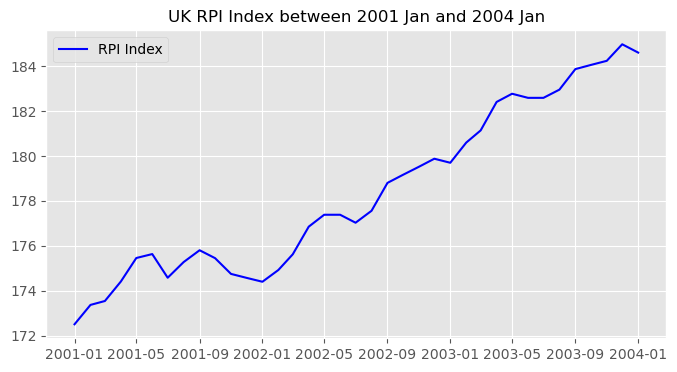

In [11]:
# Closer look to see seasonality pattern
plt.figure(figsize=(8,4))
plt.plot(RPI_index_new["2001-01-01":"2004-01-01"], 'b-', label="RPI Index")
plt.title('UK RPI Index between 2001 Jan and 2004 Jan', size=12)
plt.legend()
plt.savefig(path_to_savefig + 'RPI_index_20012004.png')

In [12]:
q2_obj_ts = RPI_pct_change_ts_monthly_new.copy().squeeze() # pd.Series

In [13]:
monthly_avg = q2_obj_ts.groupby(q2_obj_ts.index.month).mean()
monthly_std = q2_obj_ts.groupby(q2_obj_ts.index.month).std()
monthly_counts = q2_obj_ts.groupby(q2_obj_ts.index.month).count()

overall_avg = q2_obj_ts.mean()
overall_std = q2_obj_ts.std()

In [14]:
# Seasonality check
bar = 3
significant = lambda z: 'significant' if np.abs(z) > bar else 'not significant'

In [15]:
# Z-score between highest avg and lowest avg
r_hi = np.argmax(monthly_avg) + 1
r_lo = np.argmin(monthly_avg) + 1

Z_lo_hi = (monthly_avg.loc[r_hi] - monthly_avg.loc[r_lo]) /\
            np.sqrt(monthly_std.loc[r_hi]**2 / monthly_counts.loc[r_hi] +
                    monthly_std.loc[r_lo]**2 / monthly_counts.loc[r_lo])

print('Highest average month: ', r_hi, "Monthly average: ", monthly_avg.loc[r_hi])
print('Lowest average month: ', r_lo, "Monthly average: ", monthly_avg.loc[r_lo])
print(f'Z-score between highest average and lowest average: {Z_lo_hi} -- {significant(Z_lo_hi)}')

Highest average month:  4 Monthly average:  0.9486486486486487
Lowest average month:  1 Monthly average:  -0.29473684210526324
Z-score between highest average and lowest average: 9.39309725807589 -- significant


In [16]:
# Z-score between highest avg and overall avg
r_hi = np.argmax(monthly_avg) + 1

Z_hi_overall = (monthly_avg.loc[r_hi] - overall_avg) /\
            np.sqrt(monthly_std.loc[r_hi]**2 / monthly_counts.loc[r_hi] +
                    overall_std**2 / len(q2_obj_ts))

print(f'Z-score between highest average and overall average: {Z_hi_overall} -- {significant(Z_hi_overall)}')

Z-score between highest average and overall average: 5.527994165576264 -- significant


In [17]:
# Z-score between lowest avg and overall avg
r_lo = np.argmin(monthly_avg) + 1

Z_lo_overall = (monthly_avg.loc[r_lo] - overall_avg) /\
            np.sqrt(monthly_std.loc[r_lo]**2 / monthly_counts.loc[r_lo] +
                    overall_std**2 / len(q2_obj_ts))

print(f'Z-score between highest average and overall average: {Z_lo_overall} -- {significant(Z_lo_overall)}')

Z-score between highest average and overall average: -8.505173196938403 -- significant


In [18]:
# Z-score between each month and overall avg (only print significant pairs)
for m in range(1,13):
    Z = (monthly_avg.loc[m] - overall_avg) /\
            np.sqrt(monthly_std.loc[m]**2 / monthly_counts.loc[m] +
                    overall_std**2 / len(q2_obj_ts))

    if significant(Z) == 'significant':
        print(f'Z-score between month {m} and overall average: {Z} -- {significant(Z)}')
        print(f'\n Month {m} average: {np.round(monthly_avg.loc[m], 4)}, overall average: {np.round(overall_avg, 4)} \n')

Z-score between month 1 and overall average: -8.505173196938403 -- significant

 Month 1 average: -0.2947, overall average: 0.3054 

Z-score between month 2 and overall average: 7.251357313461334 -- significant

 Month 2 average: 0.6, overall average: 0.3054 

Z-score between month 4 and overall average: 5.527994165576264 -- significant

 Month 4 average: 0.9486, overall average: 0.3054 

Z-score between month 7 and overall average: -6.955997709824493 -- significant

 Month 7 average: -0.0865, overall average: 0.3054 



In [19]:
# Z-score between each month and the next month (only print significant pairs)
for m1 in range(1, 13):
    m2 = m1 + 1 if m1 < 12 else 1 
    Z = (monthly_avg.loc[m1] - monthly_avg.loc[m2]) /\
        np.sqrt(monthly_std.loc[m1]**2 / monthly_counts.loc[m1] +
                monthly_std.loc[m2]**2 / monthly_counts.loc[m2])
    
    if significant(Z) == 'significant':
        print(f'Z-score between month {m1} and month {m2}: {Z} -- {significant(Z)}')
        print(f'\n Month {m1} average: {np.round(monthly_avg.loc[m1], 4)}, Month {m2} average: {np.round(monthly_avg.loc[m2], 4)} \n')

Z-score between month 1 and month 2: -11.922140964111733 -- significant

 Month 1 average: -0.2947, Month 2 average: 0.6 

Z-score between month 2 and month 3: 4.5324212013537934 -- significant

 Month 2 average: 0.6, Month 3 average: 0.3757 

Z-score between month 3 and month 4: -4.784795934039952 -- significant

 Month 3 average: 0.3757, Month 4 average: 0.9486 

Z-score between month 4 and month 5: 4.881603144570822 -- significant

 Month 4 average: 0.9486, Month 5 average: 0.3676 

Z-score between month 6 and month 7: 4.490315444400765 -- significant

 Month 6 average: 0.2108, Month 7 average: -0.0865 

Z-score between month 7 and month 8: -7.831650689857177 -- significant

 Month 7 average: -0.0865, Month 8 average: 0.4432 

Z-score between month 12 and month 1: 6.469490113175267 -- significant

 Month 12 average: 0.3216, Month 1 average: -0.2947 



## Q3 - ZCIS's predictability to inflation

Used to present the 'forecastability' in swap rate to real annual inflation

In [20]:
path_to_example_swap_short_term = "data/ZCIS_data/BPSWIT1 BGN Curncy.xlsx"
path_to_example_swap_long_term = "data/ZCIS_data/BPSWIT20 BGN Curncy.xlsx"

demo_swap_short_term = pd.read_excel(path_to_example_swap_short_term).dropna()
demo_swap_long_term = pd.read_excel(path_to_example_swap_long_term).dropna()

demo_swap_short_term.iloc[:,0] = pd.to_datetime(demo_swap_short_term.iloc[:,0], format='%m/%d/%Y')
demo_swap_short_term = demo_swap_short_term.set_index('Date')
demo_swap_short_term.index.name = None
demo_swap_short_term.index = demo_swap_short_term.index.to_period('M').to_timestamp()
demo_swap_short_term = demo_swap_short_term[::-1]

demo_swap_long_term.iloc[:,0] = pd.to_datetime(demo_swap_long_term.iloc[:,0], format='%m/%d/%Y')
demo_swap_long_term = demo_swap_long_term.set_index('Date')
demo_swap_long_term.index.name = None
demo_swap_long_term.index = demo_swap_long_term.index.to_period('M').to_timestamp()
demo_swap_long_term = demo_swap_long_term[::-1]

swap_latest_start_date = max(demo_swap_short_term.index[0], demo_swap_long_term.index[0])


In [21]:
lag = 2 # lag in months for BPSWIT
annually_compound_inflation_rate = RPI_pct_change_ts_monthly_new.copy().shift(lag)
annually_compound_inflation_rate = ((1 + annually_compound_inflation_rate/100).rolling(window=12).apply(lambda x: x.prod()) - 1) * 100


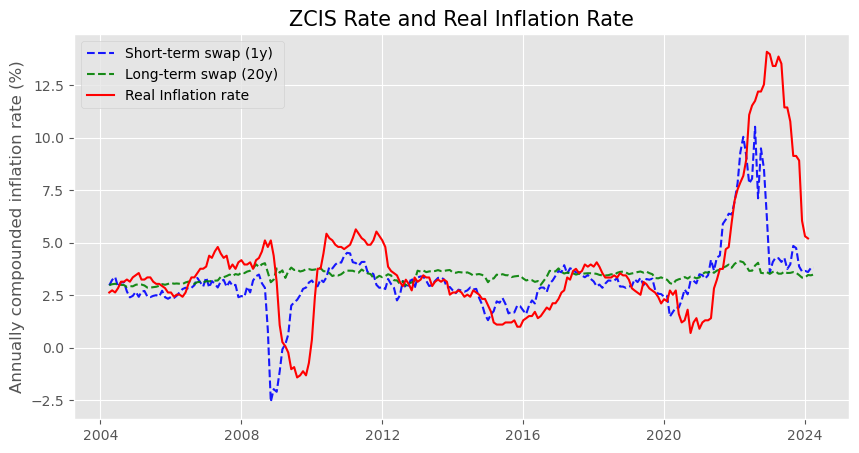

In [22]:
plt.figure(figsize=(10,5))
plt.plot(demo_swap_short_term[demo_swap_short_term.index >= swap_latest_start_date], 'b--', alpha=0.9, label='Short-term swap (1y)')
plt.plot(demo_swap_long_term[demo_swap_long_term.index >= swap_latest_start_date], 'g--', alpha=0.9, label='Long-term swap (20y)')
plt.plot(annually_compound_inflation_rate[annually_compound_inflation_rate.index >= swap_latest_start_date], 'r-', label='Real Inflation rate')
plt.title('ZCIS Rate and Real Inflation Rate', size=15)
plt.ylabel('Annually compounded inflation rate (%)', size=12)
plt.legend()
plt.savefig(path_to_savefig + 'swap_inflation.png') 
plt.show()

## Q4 - BPSWIT Exploration

Notice: All quotes are monthly data, actually the last trading day data in each month. We record the date as the first day of each month for accessibility. But it should be remembered this data is for the last day of each month.

In [23]:
# path to folder containing the ZCIS data
path_to_ZCIS_folder = "data/ZCIS_data/"

maturities = list(range(1, 11)) + [12, 15, 18, 20, 25, 30]

ZCIS_df = pd.DataFrame()

for m in maturities:
    ZSIC = pd.read_excel(path_to_ZCIS_folder + f'BPSWIT{m} BGN Curncy.xlsx').dropna()
    ZSIC = ZSIC.iloc[::-1]
    ZSIC = ZSIC.set_index('Date')
    ZSIC.index.name = None
    # only month info kept (force all day info to 01)
    ZSIC.index = pd.to_datetime(ZSIC.index, format='%m/%d/%Y').to_period('M').to_timestamp()
    ZSIC = ZSIC.rename(columns={'Last Price': f'{m}'})
    ZCIS_df = pd.concat([ZCIS_df, ZSIC], axis=1)

ZCIS_df.head()

,1,2,3,4,5,6,7,8,9,10,12,15,18,20,25,30
2003-12-01,2.940,2.920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-01-01,3.000,2.980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-02-01,2.885,2.885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-01,3.005,2.945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-04-01,2.965,2.945,NaN,NaN,2.85,NaN,2.89,NaN,NaN,2.95,2.96,3.01,NaN,2.98,3.0,2.97


In [24]:
# swap with 18y maturity is rare, only traded in following days
idx_18y = ZCIS_df.index[~ZCIS_df['18'].isnull()]
print(idx_18y)

DatetimeIndex(['2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01'],
              dtype='datetime64[ns]', freq='MS')


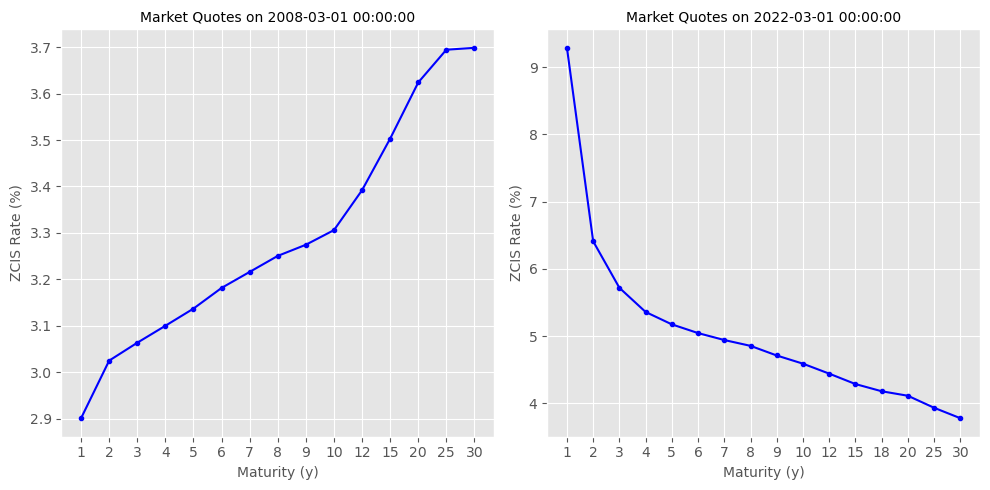

In [25]:
# Example for market quotes
today1 = pd.to_datetime("2008-03-01")
today2 = pd.to_datetime("2022-03-01")

swap_prices1 = ZCIS_df[ZCIS_df.index == today1].copy().T.dropna()
swap_prices2 = ZCIS_df[ZCIS_df.index == today2].copy().T.dropna()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(swap_prices1, 'b.-')
ax[0].set_title(f'Market Quotes on {today1}', size=10)
ax[0].set_xlabel('Maturity (y)', size=10)
ax[0].set_ylabel('ZCIS Rate (%)', size=10)

ax[1].plot(swap_prices2, 'b.-')
ax[1].set_title(f'Market Quotes on {today2}', size=10)
ax[1].set_xlabel('Maturity (y)', size=10)
ax[1].set_ylabel('ZCIS Rate (%)', size=10)

plt.tight_layout()
plt.savefig(path_to_savefig + 'ZCIS_market_quote.png')
plt.show()

In [26]:
# Pre-crisis vs Crisis Swap Quotes (Summer(May, June, July, August) 2008 vs Autumn(September, Octovber, November, December) 2008)
# Descriptive statistics of break-even inflation rates in the UK
def calculate_descriptive_stats(df, start_date, end_date):
    filtered_df = df.loc[start_date:end_date]
    desc_stats = filtered_df.aggregate(['mean', 'std', 'kurt']).transpose()
    desc_stats.columns = ['Mean', 'Std. dev.', 'Kurtosis']
    return desc_stats

# Calculate descriptive statistics for the 'pre-crisis' period (May to August)
pre_crisis_stats = calculate_descriptive_stats(ZCIS_df, '2008-05-01', '2008-08-01')
crisis_stats = calculate_descriptive_stats(ZCIS_df, '2008-09-01', '2008-12-01')

In [27]:
print('Pre-crisis Stats:')
print('----------------------------------')
print(pre_crisis_stats)

Pre-crisis Stats:
----------------------------------
        Mean  Std. dev.  Kurtosis
1   3.285875   0.190346 -3.140049
2   3.399000   0.248026 -1.080543
3   3.436000   0.234957  2.224658
4   3.479375   0.238031  3.347012
5   3.521125   0.204724  3.344296
6   3.579625   0.214017  2.669319
7   3.636125   0.220432  1.954770
8   3.677500   0.198125  1.696110
9   3.714000   0.191888  1.482163
10  3.749500   0.166104  1.484812
12  3.794875   0.151653  1.700129
15  3.841625   0.110656  0.449699
18       NaN        NaN       NaN
20  3.887375   0.099324 -3.668209
25  3.912375   0.096388 -4.742089
30  3.899500   0.087553 -3.493281


In [28]:
print('Crisis Stats:')
print('----------------------------------')
print(crisis_stats)

Crisis Stats:
----------------------------------
        Mean  Std. dev.  Kurtosis
1  -0.212125   2.530873 -2.923945
2   0.463750   1.894968 -1.856939
3   0.945875   1.621762 -0.763871
4   1.241750   1.486238 -0.882215
5   1.561375   1.316691 -0.835297
6   1.839250   1.225385 -0.986278
7   2.108750   1.044512 -0.051597
8   2.329875   0.961394 -0.865551
9   2.515125   0.896048 -0.966956
10  2.704250   0.841292 -1.750756
12  3.011625   0.659513 -1.592150
15  3.281875   0.516688 -1.584896
18       NaN        NaN       NaN
20  3.491125   0.406542 -0.805001
25  3.551000   0.400385 -0.385368
30  3.534500   0.382630  0.014770


## Q5 - 7 - Everything about curves

In [29]:
from financepy.utils.date import Date
from financepy.market.curves.discount_curve import DiscountCurve
from financepy.utils.frequency import FrequencyTypes
from financepy.utils.day_count import DayCountTypes
from financepy.market.curves.interpolator import *

####################################################################
# FINANCEPY BETA Version 0.230 - This build:  10 Apr 2024 at 00:25 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



In [30]:
# Rewrite functionality in FiancePy.InflationCurve as bug exists in its code
# A different method for finding reference index (without interpolation) used to align with our BPSWIT
def getReferenceIndex(indexDate: pd.Timestamp, RPI = RPI_index_new, lag = 2):
    refDate = indexDate - pd.DateOffset(months=lag)
    refIndex = RPI.loc[refDate].squeeze() # float
    return refIndex

def getInflationRatio(indexDate: pd.Timestamp, baseDate: pd.Timestamp = RPI_index_new.index[0], RPI = RPI_index_new, lag = 2):
    vt = getReferenceIndex(indexDate, RPI, lag)
    if baseDate == RPI_index_new.index[0]:
        lag = 0
    v0 = getReferenceIndex(baseDate, RPI, lag)
    return (vt / v0 - 1) * 100 # percentage

In [31]:
# annual spot rate -> annual forward rate
def spot_to_forward(indexDate: pd.Timestamp, ZCIS_df: pd.DataFrame, is18y: bool):
    ZCIS = ZCIS_df.copy()
    if not is18y:
        ZCIS = ZCIS.drop(columns=['18'])
    maturities_ = list(ZCIS.columns.astype(int))

    inflation_reference_index = getReferenceIndex(indexDate)
    breakeven_rate = ZCIS.loc[indexDate] # spot rate

    # annual compound 
    discount_factor = np.array(1 / ((1 + breakeven_rate / 100) ** maturities_))
    breakeven_reference_index = list((inflation_reference_index * (1 + np.array(breakeven_rate) / 100) ** np.array(maturities_)))
    
    # annual compound
    fwd = []
    for i in range(len(breakeven_reference_index)):
        if i == 0:
            _fwd = ((breakeven_reference_index[i] / inflation_reference_index) ** (1 / maturities_[i]) - 1) * 100
        else:
            _fwd = ((breakeven_reference_index[i] / breakeven_reference_index[i-1]) ** (1 / (maturities_[i] - maturities_[i-1]))-1) * 100
        fwd.append(_fwd)

    indexDate_DateType = Date(indexDate.day, indexDate.month, indexDate.year)
    maturity_dates_DateType = [indexDate_DateType.add_years(m) for m in maturities_]

    present_df = pd.DataFrame()
    present_df['Tenor'] = maturities_
    present_df['Break Even Rate (%)'] = breakeven_rate.values
    present_df['Maturity Date'] = [str(m)[3:] for m in maturity_dates_DateType]
    present_df['Break Even Reference Number'] = breakeven_reference_index
    present_df['Forward (%)'] = fwd
    present_df['Discount Factor'] = discount_factor
    present_df.set_index('Tenor', inplace=True)

    return present_df, maturities_, discount_factor, fwd

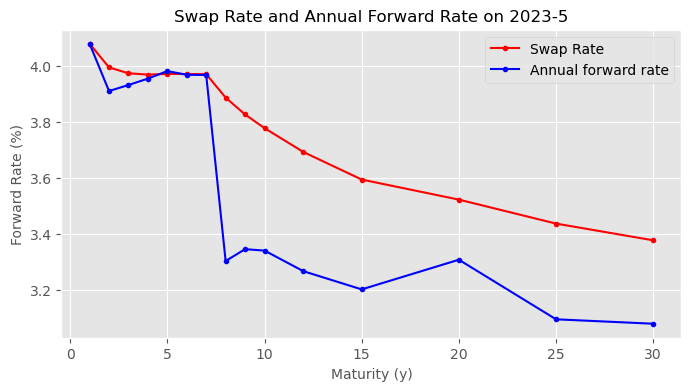

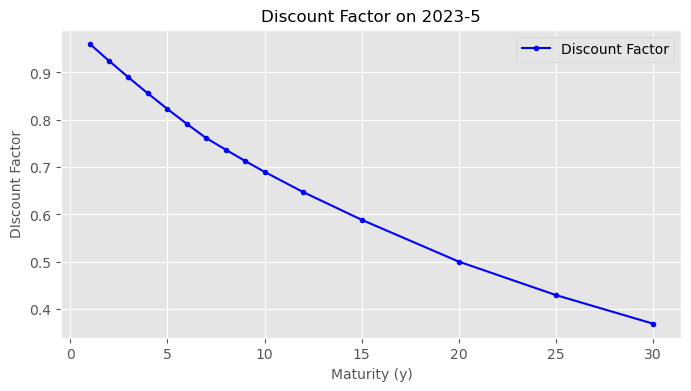

,Break Even Rate (%),Maturity Date,Break Even Reference Number,Forward (%),Discount Factor
Tenor,,,,,
1,4.0810,MAY-2024,388.942787,4.081000,0.960790
2,3.9963,MAY-2025,404.156941,3.911669,0.924622
3,3.9753,MAY-2026,420.053697,3.933313,0.889630
4,3.9705,MAY-2027,436.671447,3.956101,0.855775
5,3.9730,MAY-2028,454.064073,3.983001,0.822995
6,3.9725,MAY-2029,472.090417,3.970000,0.791570
7,3.9720,MAY-2030,490.827686,3.969000,0.761352
8,3.8882,MAY-2031,507.042120,3.303488,0.737005
9,3.8278,MAY-2032,524.007052,3.345862,0.713144


In [32]:
# Demo plots of annual forward rate and discount factor
demo_valuationDate = pd.to_datetime("2023-05-01")
demo_res = spot_to_forward(demo_valuationDate, ZCIS_df, is18y=(demo_valuationDate in idx_18y))

plt.figure(figsize=(8,4))
plt.plot(demo_res[1], ZCIS_df.loc[demo_valuationDate].dropna().T.values, 'r.-', label='Swap Rate')
plt.plot(demo_res[1], demo_res[3], 'b.-', label='Annual forward rate')
plt.title(f'Swap Rate and Annual Forward Rate on {demo_valuationDate.year}-{demo_valuationDate.month}', size=12)
plt.xlabel('Maturity (y)', size=10)
plt.ylabel('Forward Rate (%)', size=10)
plt.legend()
plt.savefig(path_to_savefig + 'demo_annual_fwd1.png')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(demo_res[1], demo_res[2], 'b.-', label='Discount Factor')
plt.title(f'Discount Factor on {demo_valuationDate.year}-{demo_valuationDate.month}', size=12)
plt.xlabel('Maturity (y)', size=10)
plt.ylabel('DIscount Factor', size=10)
plt.legend()
plt.savefig(path_to_savefig + 'demo_df1.png')
plt.show()

demo_res[0]

In [33]:
# Seasonality factor
path_to_adjusted_ts = path_to_savedata + 'adjustedts.csv'
path_to_unadjusted_ts = path_to_savedata + 'unadjustedts.csv'

## unadjusted index for RPIY
RPI = pd.read_csv('data/unadjustedts.csv')
RPI = RPI[1008:1336]
RPI['Title'] = pd.to_datetime(RPI['Title'], format='%Y %b')
RPI['unadjusted index'] = RPI['RPI:All items exc mortgage int payments and indirect taxes (RPIY) (Jan 1987=100)'].astype(float)
RPI.index = RPI['Title']

## adjusted index for RPIY (= SARPIY: Seasonally Adjusted RPIY)
RPI_adjusted = pd.read_csv('data/adjustedts.csv')
RPI_adjusted = RPI_adjusted.iloc[34:]
RPI_adjusted['Title'] = pd.to_datetime(RPI_adjusted['Title'], format='%Y %b')
RPI_adjusted.set_index(RPI_adjusted['Title'], inplace=True)
RPI_adjusted['unadjusted'] = RPI['unadjusted index']

RPI_adjusted['RPI:Seasonally adjusted all items exc. MIPs and indirect taxes (SARPIY): Indices'] = RPI_adjusted['RPI:Seasonally adjusted all items exc. MIPs and indirect taxes (SARPIY): Indices'].astype(float)

RPI_adjusted['SA factor'] = RPI_adjusted['RPI:Seasonally adjusted all items exc. MIPs and indirect taxes (SARPIY): Indices'] / RPI_adjusted['unadjusted']
RPI_adjusted['SA factor (in pct)'] = (RPI_adjusted['SA factor']-1) * 100

RPI_adjusted['unadjusted pct change'] = RPI_adjusted['unadjusted'].pct_change()
RPI_adjusted['adjusted pct change'] = RPI_adjusted['RPI:Seasonally adjusted all items exc. MIPs and indirect taxes (SARPIY): Indices'].pct_change()
RPI_adjusted.head()

SF = (RPI_adjusted['SA factor']-1) * 100
SF = SF.squeeze()
SF = SF.groupby(SF.index.month).mean()
SF

Title
1     0.802040
2     0.489920
3     0.329761
4     0.026507
5    -0.210041
6    -0.106441
7     0.373322
8     0.215275
9     0.018144
10    0.095917
11    0.190262
12    0.210032
Name: SA factor, dtype: float64

In [34]:
# Normalise our SF
SF -= np.mean(SF)
assert(np.sum(SF) < 1e-8)

In [35]:
# Use FinancePy to calculate the discount factor, interpolate, then transform back to fwd
def FitZCISCurve(valuationDate: pd.Timestamp, maturities: list, zero_rates: np.ndarray, interp_type=InterpTypes.FLAT_FWD_RATES, seasonality=False):
    
    valuationDate_DateType = Date(valuationDate.day, valuationDate.month, valuationDate.year)
    df_dates = [valuationDate_DateType.add_years(i) for i in maturities]
    df_values = zero_rates.copy() / 100 # Notice the /100 here

    # Calculate discount factor
    temp_curve = DiscountCurve(valuation_date=valuationDate_DateType, 
                               df_dates=df_dates, 
                               df_values=df_values)
    
    df_values = temp_curve._zero_to_df(valuation_date=valuationDate_DateType, 
                                       rates=df_values, 
                                       times=np.array(maturities),
                                       freq_type=FrequencyTypes.ANNUAL,
                                       day_count_type=DayCountTypes.ACT_360)

    # Create inflation curve
    inflation_curve = DiscountCurve(valuation_date=valuationDate_DateType, 
                                    df_dates=df_dates, 
                                    df_values=df_values, 
                                    interp_type=interp_type)
    
    # monthly year fraction
    year_fraction = np.linspace(1/12, maturities[-1], (maturities[-1])*12)
    interpolate_dates = [valuationDate_DateType.add_years(d) for d in year_fraction]

    # interpolated discount factor
    monthly_discount_factor = inflation_curve.df(interpolate_dates)

    # interpolated forward rate
    monthly_fwd = []
    fwd_start_date = valuationDate_DateType
    fwd_tenor_date = fwd_start_date.add_years(1/12)
    for _ in range((maturities[-1])*12):
        monthly_fwd.append(inflation_curve.fwd_rate(start_date=fwd_start_date, 
                                                    date_or_tenor=fwd_tenor_date))
        fwd_start_date = fwd_tenor_date
        fwd_tenor_date = fwd_start_date.add_years(1/12)
    
    # ON fwd
    ONfwd_rate = inflation_curve._fwd(year_fraction)

    # zero rate
    zero_rate = inflation_curve.swap_rate(effective_date = valuationDate_DateType,
                                        maturity_date = interpolate_dates)
        
    if seasonality:
        sf = SF.copy()
        sf = np.tile(np.roll(sf/100, -(valuationDate.month-1)), maturities[-1])
        monthly_fwd = np.array(monthly_fwd) + sf
        ONfwd_rate = np.array(ONfwd_rate) + sf
        N = len(zero_rate)
        decay1 = np.exp(np.arange(0, N//3) / 50)
        decay2 = 1 + np.arange(N//3, N) / 15
        decay = np.concatenate((decay1, decay2))
        zero_rate = np.array(zero_rate) + sf / decay

    return np.array(df_values), np.array(monthly_discount_factor), np.array(monthly_fwd), np.array(ONfwd_rate), np.array(zero_rate)

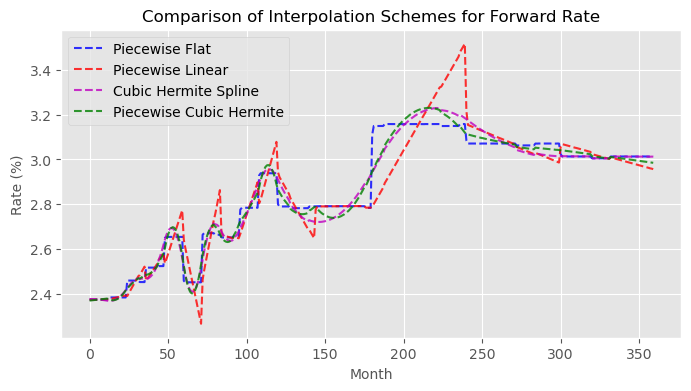

In [36]:
# comparison of different interpolation scheme
valuationDate1 = pd.to_datetime("2005-05-01")
temp_res1 = spot_to_forward(valuationDate1, ZCIS_df, is18y=(valuationDate1 in idx_18y))

res_FLAT_FWD_RATES = FitZCISCurve(valuationDate=valuationDate1, 
                    maturities=temp_res1[1], 
                    zero_rates=np.array(temp_res1[0].iloc[:,0]),
                    interp_type=InterpTypes.FLAT_FWD_RATES)

res_LINEAR_FWD_RATES = FitZCISCurve(valuationDate=valuationDate1, 
                    maturities=temp_res1[1], 
                    zero_rates=np.array(temp_res1[0].iloc[:,0]),
                    interp_type=InterpTypes.LINEAR_FWD_RATES)

res_NATCUBIC_LOG_DISCOUNT = FitZCISCurve(valuationDate=valuationDate1, 
                    maturities=temp_res1[1], 
                    zero_rates=np.array(temp_res1[0].iloc[:,0]),
                    interp_type=InterpTypes.NATCUBIC_LOG_DISCOUNT)

res_PCHIP_LOG_DISCOUNT = FitZCISCurve(valuationDate=valuationDate1, 
                    maturities=temp_res1[1], 
                    zero_rates=np.array(temp_res1[0].iloc[:,0]),
                    interp_type=InterpTypes.PCHIP_LOG_DISCOUNT)

plt.figure(figsize=(8,4))
plt.plot(res_FLAT_FWD_RATES[2] * 100, 'b--', alpha=0.8, label='Piecewise Flat')
plt.plot(res_LINEAR_FWD_RATES[2] * 100, 'r--', alpha=0.8, label='Piecewise Linear')
plt.plot(res_NATCUBIC_LOG_DISCOUNT[2] * 100, 'm--', alpha=0.8,label='Cubic Hermite Spline')
plt.plot(res_PCHIP_LOG_DISCOUNT[2] * 100, 'g--', alpha=0.8,label='Piecewise Cubic Hermite')
plt.title(f'Comparison of Interpolation Schemes for Forward Rate', size=12)
plt.xlabel('Month', size=10)
plt.ylabel('Rate (%)', size=10)
plt.legend()
plt.savefig(path_to_savefig + 'interp_compare.png')
plt.show()

In [37]:
def createCurves(valuationDates: list[pd.Timestamp], ZCIS_df: pd.DataFrame, interp_type=InterpTypes.PCHIP_LOG_DISCOUNT):

    for i, d in enumerate(valuationDates):
        zero_rates = np.array(ZCIS_df.loc[d].dropna().values)
        _, maturities_, _, annual_fwd = spot_to_forward(d, ZCIS_df, is18y=(d in idx_18y))
        _, _, m_fwd, m_ONfwd, m_zero_rate = FitZCISCurve(valuationDate=d, 
                                                        maturities=maturities_, 
                                                        zero_rates=zero_rates,
                                                        interp_type=interp_type)
        _, _, m_fwd_s, m_ONfwd_s, m_zero_rate_s = FitZCISCurve(valuationDate=d, 
                                                        maturities=maturities_, 
                                                        zero_rates=zero_rates,
                                                        interp_type=interp_type,
                                                        seasonality=True)

        # PLOT 1 - Benchmark swap quote and forward rate
        plt.figure(figsize=(8,2))
        plt.plot(maturities_, zero_rates, 'r.-', label='Swap Rate')
        plt.plot(maturities_, annual_fwd, 'b.-', label='Annual forward rate')
        plt.title(f'Benchmark Swap Quote and Annual Forward Rate in {d.year}-{d.month}', size=12)
        plt.xlabel('Maturity (y)', size=10)
        plt.ylabel('Rate (%)', size=10)
        plt.legend()
        #plt.savefig(path_to_savefig + f'annual_fwd{i+1}.png')
        plt.show()

        # PLOT 2 - Monthly Forward Rate
        plt.figure(figsize=(8,2))
        plt.plot(m_fwd * 100, 'b-', label='Unadjusted Forward Rate')
        plt.plot(m_fwd_s * 100, 'g--', alpha=0.6, label='Adjusted Forward Rate')
        plt.title(f'Monthly Forward Rate in {d.year}-{d.month}', size=12)
        plt.xlabel('Month', size=10)
        plt.ylabel('Rate (%)', size=10)
        plt.legend()
        plt.savefig(path_to_savefig + f'monthly_fwd{i+1}.png')
        plt.show()

        # PLOT 3 - ON FWD
        plt.figure(figsize=(8,2))
        plt.plot(m_ONfwd * 100, 'b-', label='Unadjusted ON FWD')
        plt.plot(m_ONfwd_s * 100, 'g--', alpha=0.8, label='Adjusted ON FWD')
        plt.plot(m_fwd * 100, 'r-', alpha = 0.6, label='Unadjusted FWD')
        #plt.plot(m_fwd_s * 100, 'g--', alpha=0.3, label='Adjusted FWD')
        plt.title(f'ON Forward Rate in {d.year}-{d.month}', size=12)
        plt.xlabel('Month', size=10)
        plt.ylabel('Rate (%)', size=10)
        plt.legend()
        plt.savefig(path_to_savefig + f'monthly_onfwd{i+1}.png')
        plt.show()

        # PLOT 4 - SWAP RATE
        plt.figure(figsize=(8,2))
        plt.plot(m_zero_rate * 100, 'b-', label='Unadjusted ZC Spot Rate')
        plt.plot(m_zero_rate_s * 100, 'g--', alpha=0.8, label='Adjusted ZC Spot Rate')
        plt.plot(np.array(maturities_) * 12, zero_rates, 'r*', label='Real ZC Spot Rate')
        plt.title(f'Monthly Spot rate in {d.year}-{d.month}', size=12)
        plt.xlabel('Month', size=10)
        plt.ylabel('Rate (%)', size=10)
        plt.legend()
        plt.savefig(path_to_savefig + f'zero_rates{i+1}.png')
        plt.show()

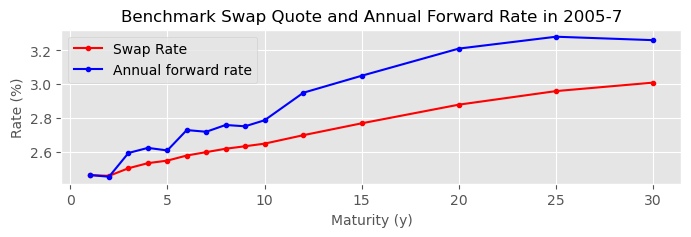

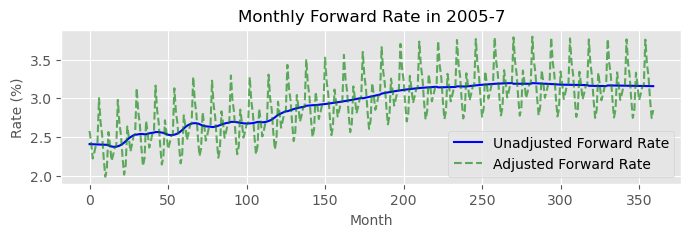

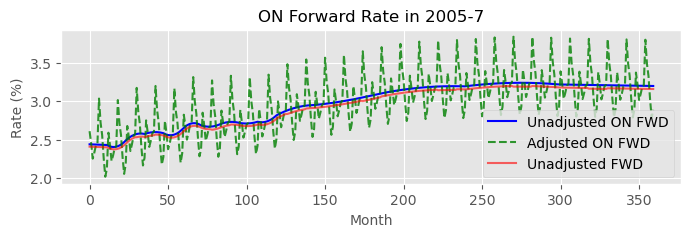

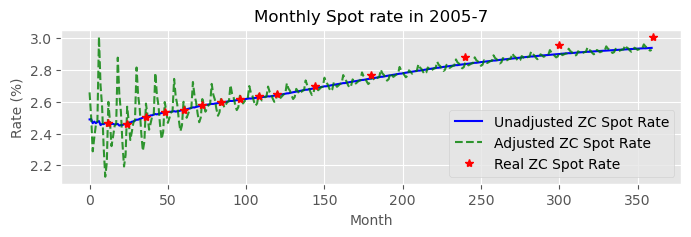

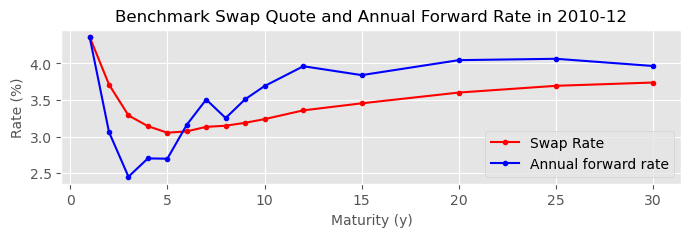

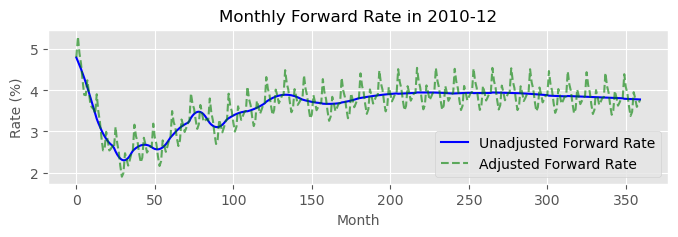

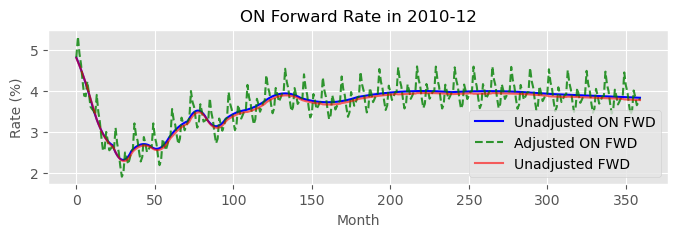

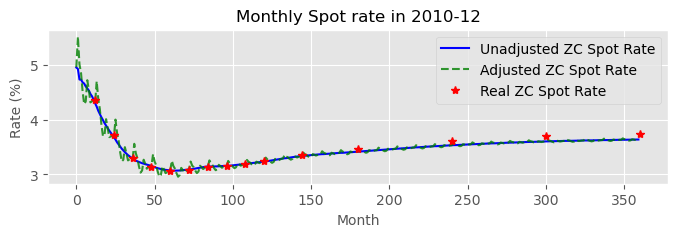

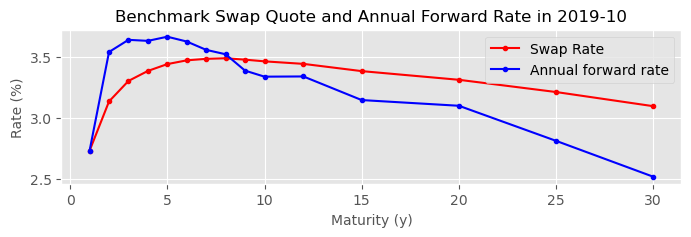

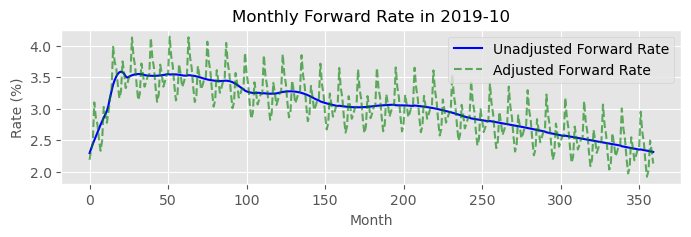

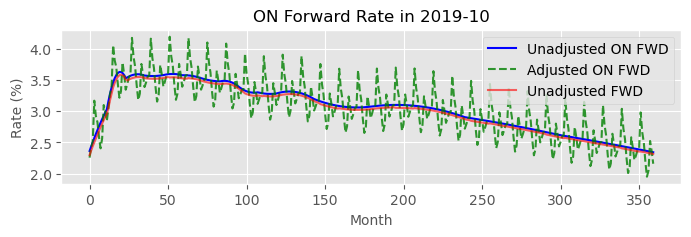

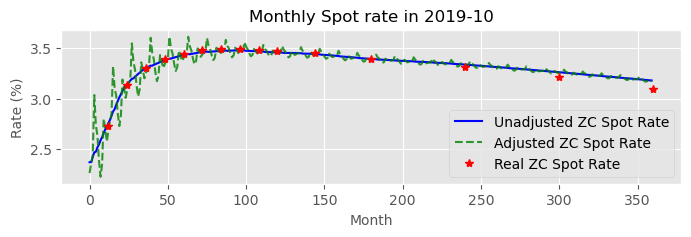

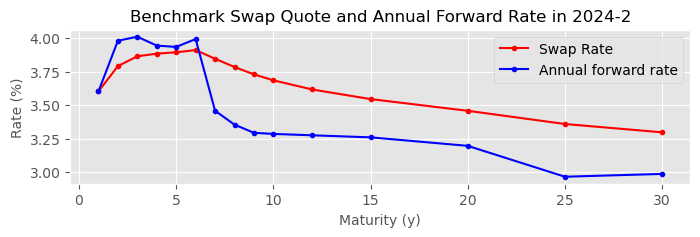

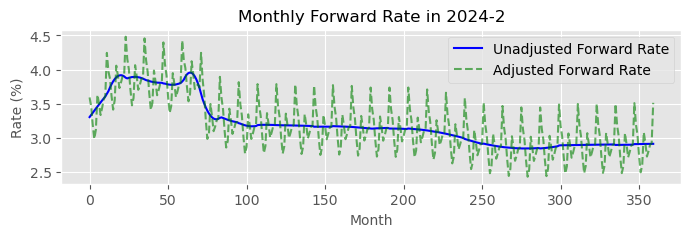

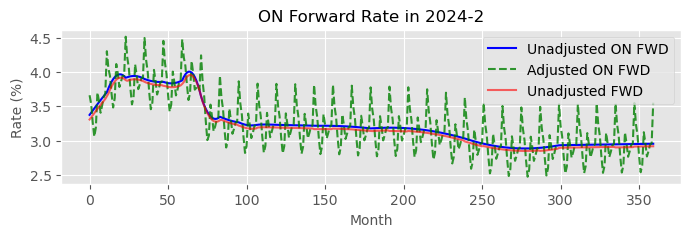

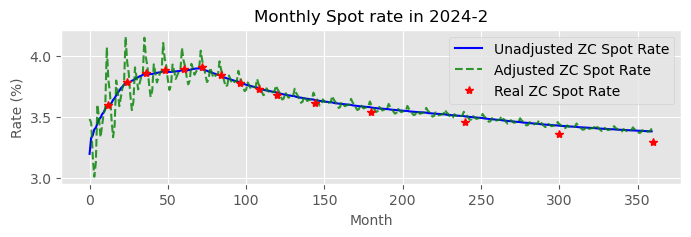

In [38]:
valuationDates = [
    pd.to_datetime("2005-07-01"),
    pd.to_datetime("2010-12-01"),
    pd.to_datetime("2019-10-01"),
    pd.to_datetime("2024-02-01"),
]
#valuationDates = [pd.to_datetime("2024-02-01")]
createCurves(valuationDates=valuationDates,
             ZCIS_df=ZCIS_df, 
             interp_type=InterpTypes.PCHIP_LOG_DISCOUNT)

In [39]:
def compareOffBenchmarkSwap(valuation_date: pd.Timestamp, offbenchmark_m: list, idx: int, interp_type=InterpTypes.PCHIP_LOG_DISCOUNT):
    start_date = str(valuation_date)[:10]
    starting_month = int(valuation_date.month)
    lst1 = offbenchmark_m
    lst2 = [str(valuation_date + pd.DateOffset(months=m))[:10] for m in offbenchmark_m]

    zero_rates = np.array(ZCIS_df.loc[valuation_date].dropna().values)
    _, maturities_, _, _ = spot_to_forward(valuation_date, ZCIS_df, is18y=(valuation_date in idx_18y))
    _, _, m_fwd, _, _ = FitZCISCurve(valuationDate=valuation_date, 
                                                    maturities=maturities_, 
                                                    zero_rates=zero_rates,
                                                    interp_type=interp_type)
    _, _, m_fwd_s, _, _ = FitZCISCurve(valuationDate=valuation_date, 
                                                    maturities=maturities_, 
                                                    zero_rates=zero_rates,
                                                    interp_type=interp_type,
                                                    seasonality=True)
    
    result = defaultdict(list)

    for i in range(len(lst1)):
        target_month = lst1[i]
        target_date = lst2[i]

        start_index = getReferenceIndex(pd.to_datetime(start_date))
        target_index = getReferenceIndex(pd.to_datetime(target_date))

        if target_month >= 12:
            years = target_month//12
            months = target_month % 12
            l1 = start_index * (1 + m_fwd_s[12 * years])**(years)
            l1 = l1 * np.product((1+ m_fwd_s[12 * years + starting_month: 12 * years + starting_month + months])**(1/12))

            l2= start_index * (1 + m_fwd[12 * years])**(years)
            l2 = l2 * np.product((1+ m_fwd[12 * years + starting_month: 12 * years + starting_month + months])**(1/12))
        else:
            l1 = start_index *np.product((1+ m_fwd_s[starting_month: starting_month + target_month])**(1/12))
            l2= start_index* np.product((1+ m_fwd[starting_month: starting_month + target_month])**(1/12))

        result['real_index'].append(target_index)
        result['adjusted'].append(l1)
        result['unadjusted'].append(l2)
    
    plt.figure(figsize=(8,2))
    plt.plot(offbenchmark_m, result['real_index'], 'r.--', label = 'real index')
    plt.plot(offbenchmark_m, result['unadjusted'], 'b.--', label = 'index from unadjusted fwd')
    plt.plot(offbenchmark_m, result['adjusted'], 'g.--', label = 'index from adjusted fwd')
    plt.xlabel('Month')
    plt.ylabel('RPI Index')
    plt.title(f'Comparison of off-benchmark ZC swap on {valuation_date.year}-{valuation_date.month}', size=12)
    plt.legend()
    plt.savefig(path_to_savefig + f'off_benchmark_{idx}.png')


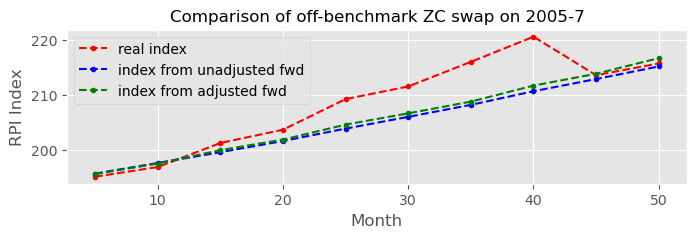

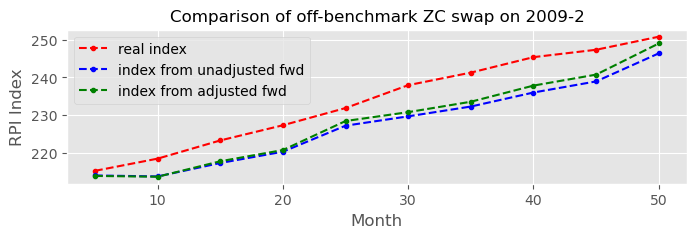

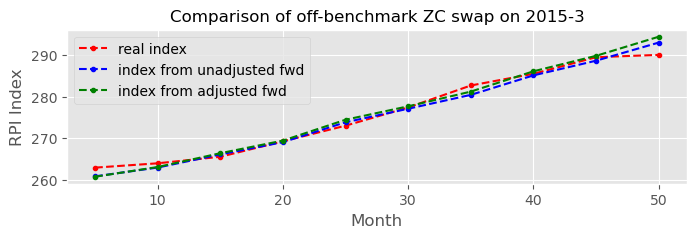

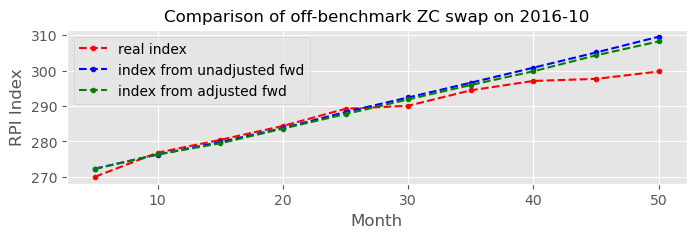

In [40]:
valuation_date = pd.to_datetime("2005-07-01")
lst1 = [5,10,15,20,25,30,35,40,45,50]
compareOffBenchmarkSwap(valuation_date, lst1, 1)

valuation_date = pd.to_datetime("2009-02-01")
lst1 = [5,10,15,20,25,30,35,40,45,50]
compareOffBenchmarkSwap(valuation_date, lst1, 2)

valuation_date = pd.to_datetime("2015-03-01")
lst1 = [5,10,15,20,25,30,35,40,45,50]
compareOffBenchmarkSwap(valuation_date, lst1, 3)

valuation_date = pd.to_datetime("2016-10-01")
lst1 = [5,10,15,20,25,30,35,40,45,50]
compareOffBenchmarkSwap(valuation_date, lst1, 4)